In [133]:
import io
import base64
import glob
import os
import cv2
import sys
import importlib
import torchvision
import matplotlib.pyplot as plt

import gzip
import json
import numpy as np
import torch
from IPython.display import HTML
from skvideo.io import FFmpegReader, ffprobe, vwrite
from torch.autograd import Variable
from ptcap.trainers import DataParallelWrapper
from ptcap.grad_cam_videos import GradCam
from ptcap.data.annotation_parser import V2Parser

sys.path.insert(0, "../")

In [134]:
# all_templates = sorted(set(validation_parser.annotations["template"]))
# print("Number of different classes: ", len(all_templates))
# class_dict = {k: idx for idx, k in enumerate(all_templates)}

In [135]:
int2label={
 0: 'Approaching [something] with your camera',
 1: 'Attaching [something] to [something]',
 2: 'Bending [something] so that it deforms',
 3: 'Bending [something] until it breaks',
 4: 'Burying [something] in [something]',
 5: 'Closing [something]',
 6: 'Covering [something] with [something]',
 7: 'Digging [something] out of [something]',
 8: 'Dropping [something] behind [something]',
 9: 'Dropping [something] in front of [something]',
 10: 'Dropping [something] into [something]',
 11: 'Dropping [something] next to [something]',
 12: 'Dropping [something] onto [something]',
 13: 'Failing to put [something] into [something] because [something] does not fit',
 14: 'Folding [something]',
 15: 'Hitting [something] with [something]',
 16: 'Holding [something]',
 17: 'Holding [something] behind [something]',
 18: 'Holding [something] in front of [something]',
 19: 'Holding [something] next to [something]',
 20: 'Holding [something] over [something]',
 21: 'Laying [something] on the table on its side, not upright',
 22: 'Letting [something] roll along a flat surface',
 23: 'Letting [something] roll down a slanted surface',
 24: 'Letting [something] roll up a slanted surface, so it rolls back down',
 25: 'Lifting [something] up completely without letting it drop down',
 26: 'Lifting [something] up completely, then letting it drop down',
 27: 'Lifting [something] with [something] on it',
 28: 'Lifting a surface with [something] on it but not enough for it to slide down',
 29: 'Lifting a surface with [something] on it until it starts sliding down',
 30: 'Lifting up one end of [something] without letting it drop down',
 31: 'Lifting up one end of [something], then letting it drop down',
 32: 'Moving [part] of [something]',
 33: 'Moving [something] across a surface until it falls down',
 34: 'Moving [something] across a surface without it falling down',
 35: 'Moving [something] and [something] away from each other',
 36: 'Moving [something] and [something] closer to each other',
 37: 'Moving [something] and [something] so they collide with each other',
 38: 'Moving [something] and [something] so they pass each other',
 39: 'Moving [something] away from [something]',
 40: 'Moving [something] away from the camera',
 41: 'Moving [something] closer to [something]',
 42: 'Moving [something] down',
 43: 'Moving [something] towards the camera',
 44: 'Moving [something] up',
 45: 'Moving away from [something] with your camera',
 46: 'Opening [something]',
 47: 'Picking [something] up',
 48: 'Piling [something] up',
 49: 'Plugging [something] into [something]',
 50: 'Plugging [something] into [something] but pulling it right out as you remove your hand',
 51: 'Poking [something] so it slightly moves',
 52: "Poking [something] so lightly that it doesn't or almost doesn't move",
 53: 'Poking [something] so that it falls over',
 54: 'Poking [something] so that it spins around',
 55: 'Poking a hole into [some substance]',
 56: 'Poking a hole into [something soft]',
 57: 'Poking a stack of [something] so the stack collapses',
 58: 'Poking a stack of [something] without the stack collapsing',
 59: 'Pouring [something] into [something]',
 60: 'Pouring [something] into [something] until it overflows',
 61: 'Pouring [something] onto [something]',
 62: 'Pouring [something] out of [something]',
 63: 'Pretending or failing to wipe [something] off of [something]',
 64: 'Pretending or trying and failing to twist [something]',
 65: 'Pretending to be tearing [something that is not tearable]',
 66: 'Pretending to close [something] without actually closing it',
 67: 'Pretending to open [something] without actually opening it',
 68: 'Pretending to pick [something] up',
 69: 'Pretending to poke [something]',
 70: 'Pretending to pour [something] out of [something], but [something] is empty',
 71: 'Pretending to put [something] behind [something]',
 72: 'Pretending to put [something] into [something]',
 73: 'Pretending to put [something] next to [something]',
 74: 'Pretending to put [something] on a surface',
 75: 'Pretending to put [something] onto [something]',
 76: 'Pretending to put [something] underneath [something]',
 77: 'Pretending to scoop [something] up with [something]',
 78: 'Pretending to spread air onto [something]',
 79: 'Pretending to sprinkle air onto [something]',
 80: 'Pretending to squeeze [something]',
 81: 'Pretending to take [something] from [somewhere]',
 82: 'Pretending to take [something] out of [something]',
 83: 'Pretending to throw [something]',
 84: 'Pretending to turn [something] upside down',
 85: 'Pulling [something] from behind of [something]',
 86: 'Pulling [something] from left to right',
 87: 'Pulling [something] from right to left',
 88: 'Pulling [something] onto [something]',
 89: 'Pulling [something] out of [something]',
 90: 'Pulling two ends of [something] but nothing happens',
 91: 'Pulling two ends of [something] so that it gets stretched',
 92: 'Pulling two ends of [something] so that it separates into two pieces',
 93: 'Pushing [something] from left to right',
 94: 'Pushing [something] from right to left',
 95: 'Pushing [something] off of [something]',
 96: 'Pushing [something] onto [something]',
 97: 'Pushing [something] so it spins',
 98: "Pushing [something] so that it almost falls off but doesn't",
 99: 'Pushing [something] so that it falls off the table',
 100: 'Pushing [something] so that it slightly moves',
 101: 'Pushing [something] with [something]',
 102: 'Putting [number of] [something] onto [something]',
 103: 'Putting [something similar to other things that are already on the table]',
 104: 'Putting [something that cannot actually stand upright] upright on the table, so it falls on its side',
 105: 'Putting [something] and [something] on the table',
 106: 'Putting [something] behind [something]',
 107: 'Putting [something] in front of [something]',
 108: 'Putting [something] into [something]',
 109: 'Putting [something] next to [something]',
 110: 'Putting [something] on a flat surface without letting it roll',
 111: 'Putting [something] on a surface',
 112: 'Putting [something] on the edge of [something] so it is not supported and falls down',
 113: 'Putting [something] onto [something else that cannot support it] so it falls down',
 114: 'Putting [something] onto [something]',
 115: "Putting [something] onto a slanted surface but it doesn't glide down",
 116: "Putting [something] that can't roll onto a slanted surface, so it slides down",
 117: "Putting [something] that can't roll onto a slanted surface, so it stays where it is",
 118: 'Putting [something] underneath [something]',
 119: 'Putting [something] upright on the table',
 120: 'Putting [something], [something] and [something] on the table',
 121: 'Removing [something], revealing [something] behind',
 122: 'Rolling [something] on a flat surface',
 123: 'Scooping [something] up with [something]',
 124: 'Showing [something] behind [something]',
 125: 'Showing [something] next to [something]',
 126: 'Showing [something] on top of [something]',
 127: 'Showing [something] to the camera',
 128: 'Showing a photo of [something] to the camera',
 129: 'Showing that [something] is empty',
 130: 'Showing that [something] is inside [something]',
 131: 'Spilling [something] behind [something]',
 132: 'Spilling [something] next to [something]',
 133: 'Spilling [something] onto [something]',
 134: 'Spinning [something] so it continues spinning',
 135: 'Spinning [something] that quickly stops spinning',
 136: 'Spreading [something] onto [something]',
 137: 'Sprinkling [something] onto [something]',
 138: 'Squeezing [something]',
 139: 'Stacking [number of] [something]',
 140: 'Stuffing [something] into [something]',
 141: 'Taking [one of many similar things on the table]',
 142: 'Taking [something] from [somewhere]',
 143: 'Taking [something] out of [something]',
 144: 'Tearing [something] into two pieces',
 145: 'Tearing [something] just a little bit',
 146: 'Throwing [something]',
 147: 'Throwing [something] against [something]',
 148: 'Throwing [something] in the air and catching it',
 149: 'Throwing [something] in the air and letting it fall',
 150: 'Throwing [something] onto a surface',
 151: "Tilting [something] with [something] on it slightly so it doesn't fall down",
 152: 'Tilting [something] with [something] on it until it falls off',
 153: 'Tipping [something] over',
 154: 'Tipping [something] with [something in it] over, so [something in it] falls out',
 155: 'Touching (without moving) [part] of [something]',
 156: "Trying but failing to attach [something] to [something] because it doesn't stick",
 157: 'Trying to bend [something unbendable] so nothing happens',
 158: 'Trying to pour [something] into [something], but missing so it spills next to it',
 159: 'Turning [something] upside down',
 160: 'Turning the camera downwards while filming [something]',
 161: 'Turning the camera left while filming [something]',
 162: 'Turning the camera right while filming [something]',
 163: 'Turning the camera upwards while filming [something]',
 164: 'Twisting (wringing) [something] wet until water comes out',
 165: 'Twisting [something]',
 166: 'Uncovering [something]',
 167: 'Unfolding [something]',
 168: 'Wiping [something] off of [something]',
 169: '[Something] being deflected from [something]',
 170: '[Something] colliding with [something] and both are being deflected',
 171: '[Something] colliding with [something] and both come to a halt',
 172: '[Something] falling like a feather or paper',
 173: '[Something] falling like a rock'}

## Load Model

In [136]:
from ptcap.model.captioners import EncoderDecoder
from ptcap.model.encoders import C3dLSTMEncoder
from ptcap.model.two_stream_encoders import TwoStreamEncoder
from ptcap.model.external_encoders import FCEncoder, JesterEncoder, BIJesterEncoder
from ptcap.model.decoders import LSTMDecoder, CoupledLSTMDecoder

net = EncoderDecoder(
        encoder=TwoStreamEncoder,
        decoder=CoupledLSTMDecoder,
        encoder_kwargs={"encoder_output_size": 1024,"c2d_out_ch": 0,
                   "c3d_out_ch": 32, "rnn_output_size":1024},#, "pretrained_path": "/home/farzaneh/PycharmProjects/pretrained_nets/fully_conv_net_on_smtsmt_20170627/model.checkpoint"},
        decoder_kwargs={"embedding_size": 256, "hidden_size": 1024, "num_lstm_layers": 2, 
        "vocab_size": 2728, "num_step" :17, "fc_size":1024}, 
        gpus=[0]).cuda()
net = DataParallelWrapper(net, device_ids=[0]).cuda(0)

gpus: [0]


In [137]:
# path = '/home/farzaneh/PycharmProjects/pytorch-captioning/results/clapnet_balanced_tokens/'
path = '/home/farzaneh/PycharmProjects/pytorch-captioning/results/ECCV/v2_gulp160_two_stream_c2_0_c3_32_labels_cutoff5_classif1_cap0/'

checkpoint = torch.load(path + '/model.best')


net.load_state_dict(checkpoint["model"])
#checkpoint["model"].keys()

In [138]:
num_params = sum([np.prod(param.size()) 
                  for param in net.module.encoder.parameters()])
print('Total number of parameters: {}'.format(num_params))

Total number of parameters: 8909248


In [7]:
net.module.encoder

TwoStreamEncoder(
  (c3d_extractor): C3dExtractor(
    (conv1): CNN3dLayer(
      (conv): Conv3d (3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): ReLU()
      (batchnorm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    )
    (conv2): CNN3dLayer(
      (conv): Conv3d (32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): ReLU()
      (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (conv3): CNN3dLayer(
      (conv): Conv3d (64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (activation): ReLU()
      (batchnorm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True)
    )
    (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (pool3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, di

## Load Data

In [8]:
validation_path = "/data/20bn-something-something-v2/v2-validation.json"
videos_folder = "/data-ssd/v2-gulp-160/"
caption_type = "label"

validation_parser = V2Parser(validation_path,
                                            videos_folder,
                               caption_type=caption_type)

In [9]:
validation_parser.annotations["template"]
all_templates = sorted(set(validation_parser.annotations["template"]))
print("Number of different classes: ", len(all_templates))
class_dict = {k: idx for idx, k in enumerate(all_templates)}
inv_class_dict = {idx:k for k, idx in class_dict.items()}
#class_dict = [class_dict[p] for p in all_templates]

Number of different classes:  174


In [10]:
def path_generator(annotation_path, root_path):
    with open(annotation_path, "rt") as f:
        annotations = json.load(f)
    files = validation_parser.get_video_paths()
    captions = validation_parser.get_captions()
    classif_labels = validation_parser.get_labels()
    return ((os.path.join(root_path, f), cap, classif_l) for f, cap, classif_l in zip(files, captions, classif_labels))
path_gen = path_generator('/data/20bn-something-something-v2/v2-train.json', 
                          '/data/20bn-something-something-v2/')

Number of different classes:  174
Number of different action groups:  50


In [11]:
from rtorchn.data.fileio import MpegReader

reader = MpegReader(12, (128, 128), keep_aspect_ratio=False)

## Preprocessing

In [12]:
from rtorchn.data.preprocessing import default_evaluation_preprocesser

preprocessor = default_evaluation_preprocesser([48, 96, 96], 64.)

## Tokenizer

In [13]:
from ptcap.data.tokenizer import Tokenizer

USER_MAXLEN=17
tokenizer = Tokenizer(user_maxlen=USER_MAXLEN)
tokenizer.load_dictionaries(path)

## Model Layers

In [14]:
def run_model2(net, video):

    gradients = []
    layer_feats = []
    x = video
    ###########################################################################################

#     for name, module in net.module.encoder.c3d_extractor._modules.items():
#         print(name)
#         x = module(x)
#         if "conv4" in name:
#             x.register_hook(lambda grad:gradients.append(grad))
#             print("U"*10)
#             print(gradients)
#             print("grad appended")
#             layer_feats += [x]

#     x = x.view(x.size()[0:3])  # [batch_size*num_feature*num_step](8*256*48)
#     c3d2 = x.permute(0, 2, 1)
#     layer_feats = layer_feats[0]
#     print(gradients)
#     ###########################################################################################
    conv1_feats = net.module.encoder.c3d_extractor.conv1(video)
    pool1_feats = net.module.encoder.c3d_extractor.pool1(conv1_feats)

    conv2_feats = net.module.encoder.c3d_extractor.conv2(pool1_feats)
    pool2_feats = net.module.encoder.c3d_extractor.pool2(conv2_feats)

    conv3_feats = net.module.encoder.c3d_extractor.conv3(pool2_feats)  

    pool3_feats = net.module.encoder.c3d_extractor.pool3(conv3_feats)  

    conv4_feats = net.module.encoder.c3d_extractor.conv4(pool3_feats) 


    conv5_feats = net.module.encoder.c3d_extractor.conv5(conv4_feats)   
    conv6_feats = net.module.encoder.c3d_extractor.conv6(conv5_feats)   
    
 # REGISTER HOOK ##
    layer_feats = conv6_feats
    conv6_feats.register_hook(lambda grad:gradients.append(grad))

    pool4_feats = net.module.encoder.c3d_extractor.pool4(conv6_feats)   


    pool4_feats = pool4_feats.view(pool4_feats.size()[0:3])   

    c3d2 = pool4_feats.permute(0, 2, 1)   

#     c3d2 = net.module.encoder.c3d_extractor.extract_features(video)
    ###########################################################################################
#     c2d2 = net.module.encoder.c3d_extractor.extract_features(video)

#     h2 = torch.cat([c2d2, c3d2 ], 2)
    h2 = torch.cat([c3d2], 2)

    #net.module.encoder.lstm.flatten_parameters()
    lstm_outputs2, _ = net.module.encoder.lstm(h2) 
    oo =  net.module.encoder.dropout(net.module.encoder.relu(net.module.encoder.fc(lstm_outputs2)))

        #h = net.module.encoder.extract_features(video)
    net_classif_output2 = net.module.predict_from_encoder_features(oo)

    return net_classif_output2,layer_feats, gradients

In [15]:
def run_model(net, input_tuple ):
    video, caption = input_tuple
    probs, classif_probs1 = net((video, caption), False)
    return classif_probs1

## CAM calculating

In [16]:
import torch.nn as nn
def calc_cam(net, net_output, layer_feats, target_index, vocab_size, gradients, frame_number):
 
    one_hot = np.zeros((1, vocab_size), dtype=np.float32)
    one_hot[0][target_index] = 1
    one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
    y_c = torch.sum(one_hot.cuda() * net_output)

    net.module.encoder.c3d_extractor.conv6.zero_grad()
    #net.module.classif_layer.zero_grad()
    y_c.backward(retain_graph=True)
    print("backward"*10)

    grads_val = gradients[0].cpu().data.numpy() #take the only element out of gradients list
    feats_numpy = layer_feats.cpu().data.numpy()[0, :] #first sample of batch
    
#     weights = np.mean(grads_val, axis=( 3, 4))[0, :, frame_number]   #grads_val: (1, 256, 48, 6, 6)
#     cam = np.ones(feats_numpy.shape[1:], dtype=np.float32)
#     weights = weights / weights.max()
#     for ii, ww in enumerate(weights):
#         cam += ww * feats_numpy[ii, :, :, :]


    weights = np.mean(grads_val, axis=( 3, 4))[0, :, :]
    weights = weights / weights.max()

    cam = np.ones(feats_numpy.shape[1:], dtype=np.float32)

    for t in range(48):
        for c in range(256):
            cam[t] += weights[c,t] * feats_numpy[c, t, :, :]
            
            
#     weights = np.mean(grads_val, axis=(2, 3, 4))[0]
#     weights = weights / weights.max()

#     cam = np.ones(feats_numpy.shape[1:], dtype=np.float32)

#     for i, w in enumerate(weights):
#         cam += w * feats_numpy[i, :, :, :]revrere
             
    cam_relu = np.maximum(cam, 0)
    return cam_relu

In [19]:
for i in range(500):
    path_to_video, _, classif_label = next(path_gen)

pppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp
Tearing [something] just a little bit
[145]
[144]
[144]
***************
backwardbackwardbackwardbackwardbackwardbackwardbackwardbackwardbackwardbackward
0


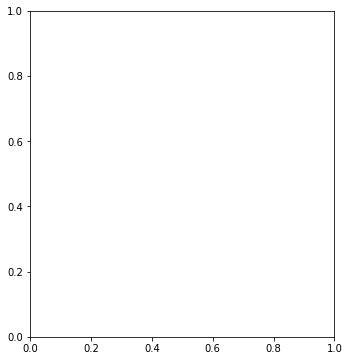

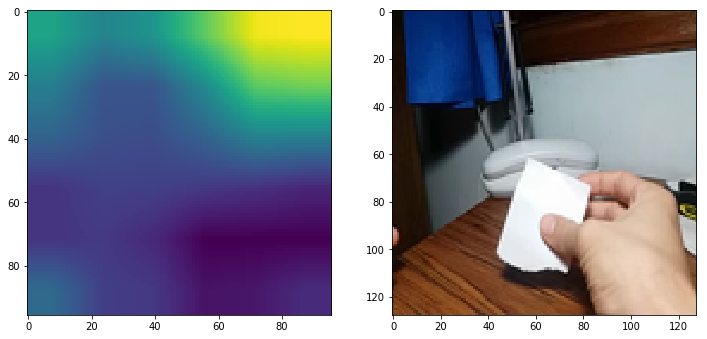

1


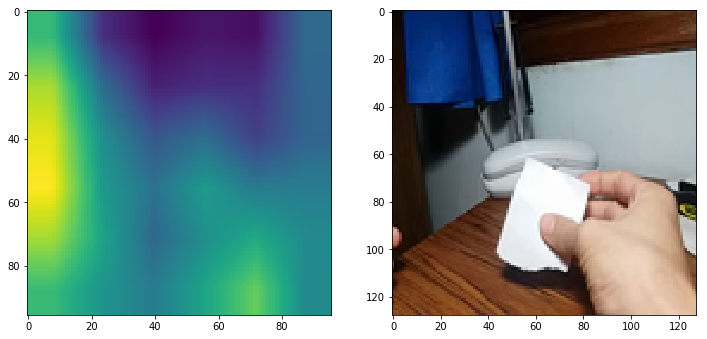

2


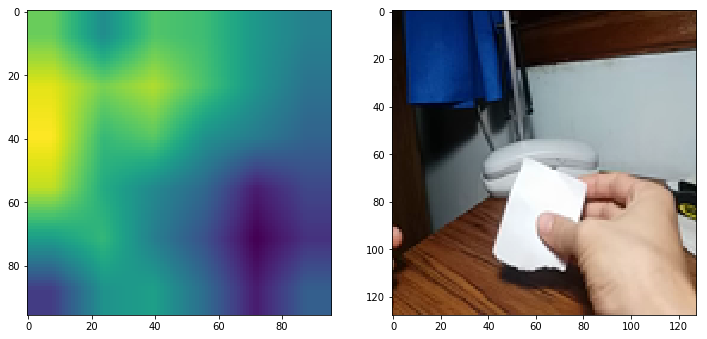

3


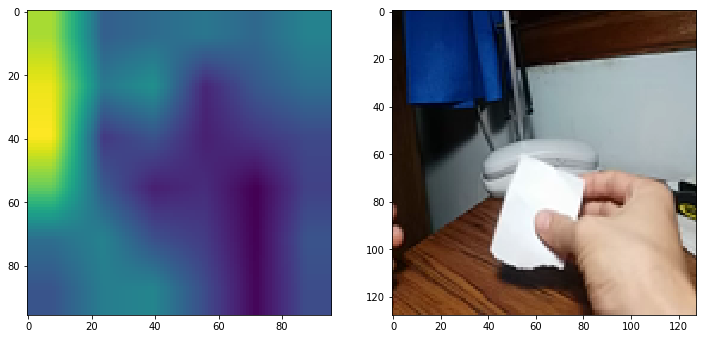

4


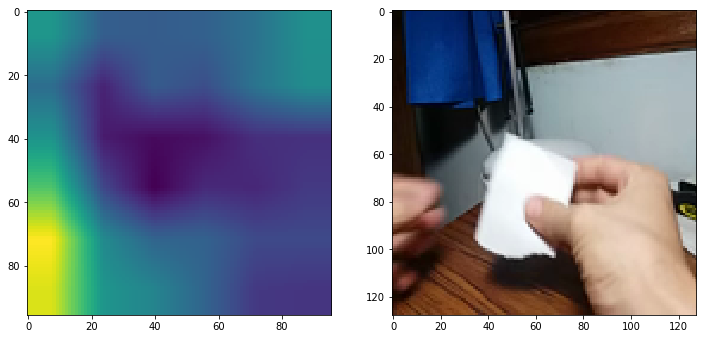

5


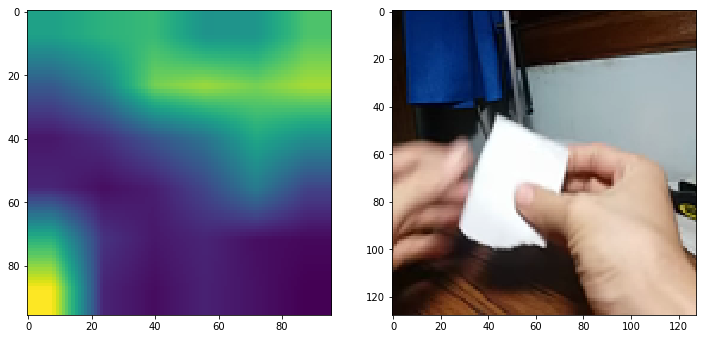

6


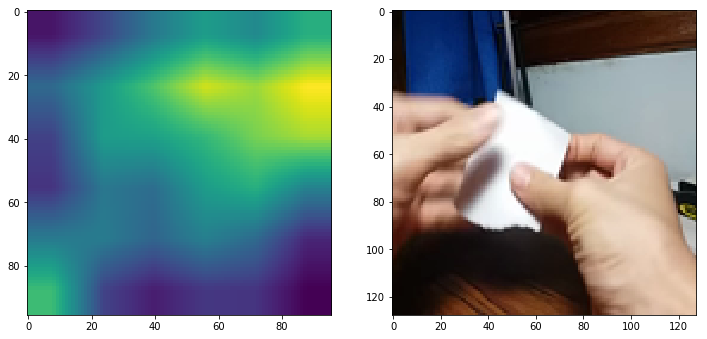

7


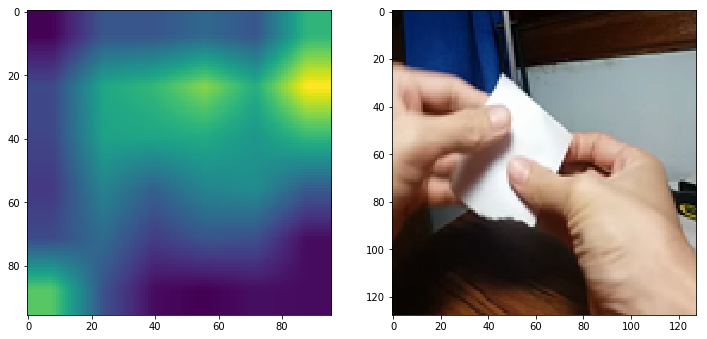

8


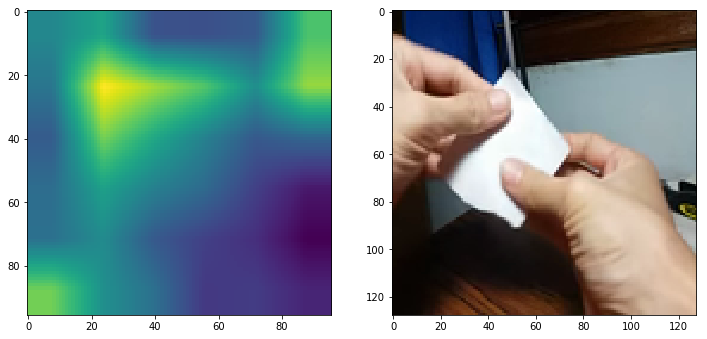

9


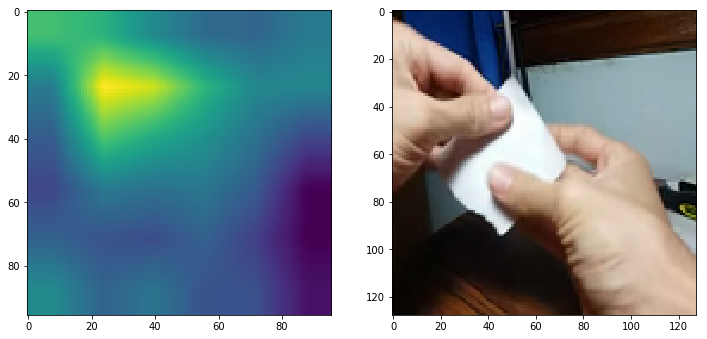

10


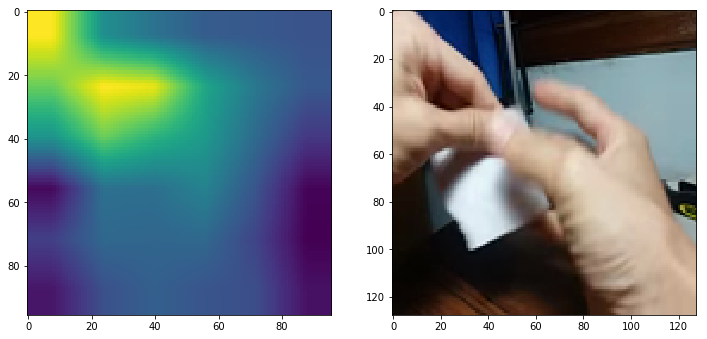

11


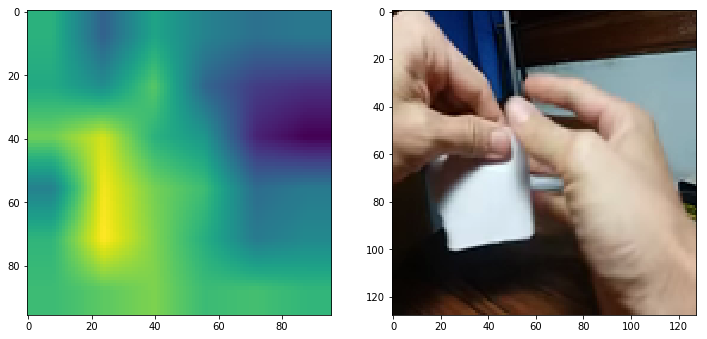

12


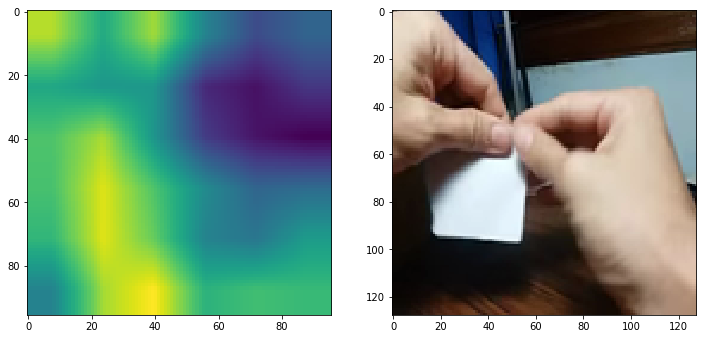

13


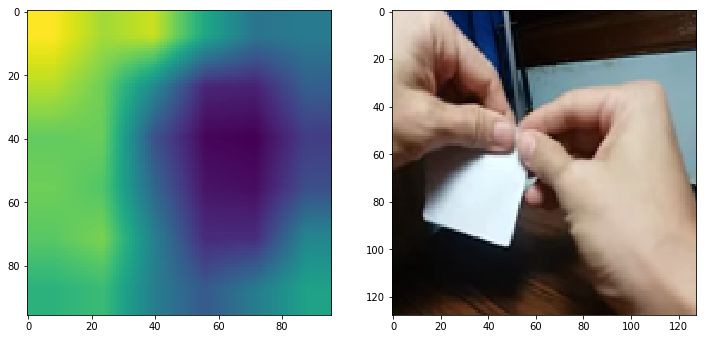

14


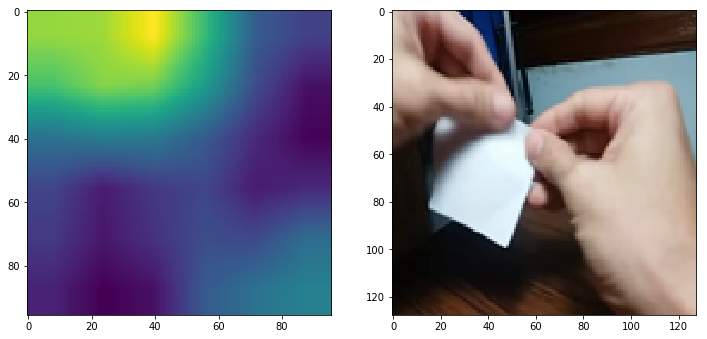

15


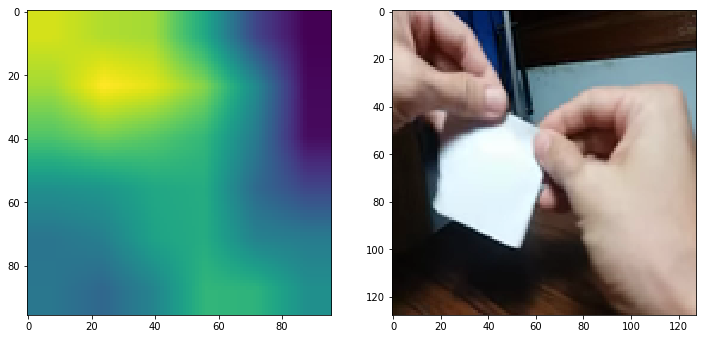

16


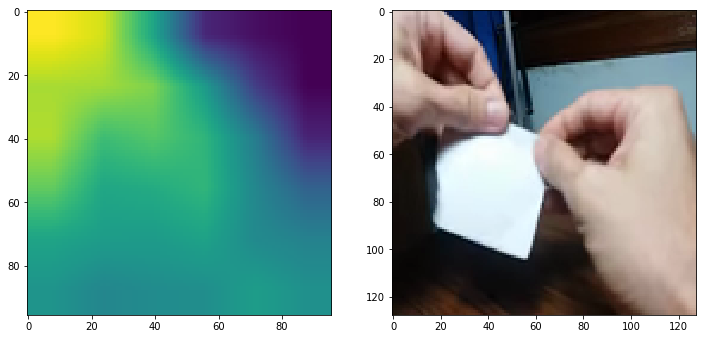

17


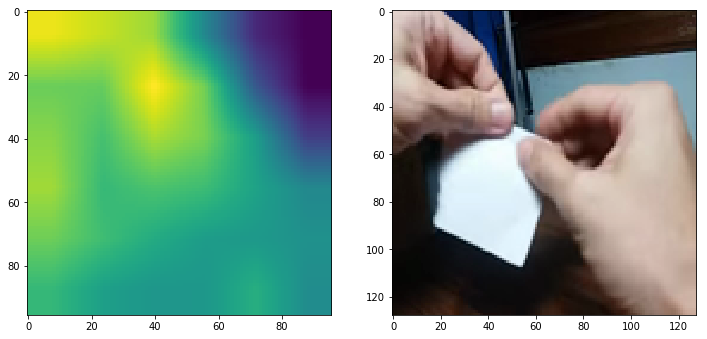

18


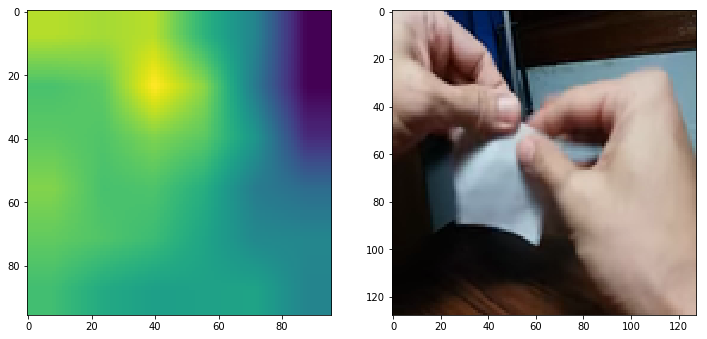

19


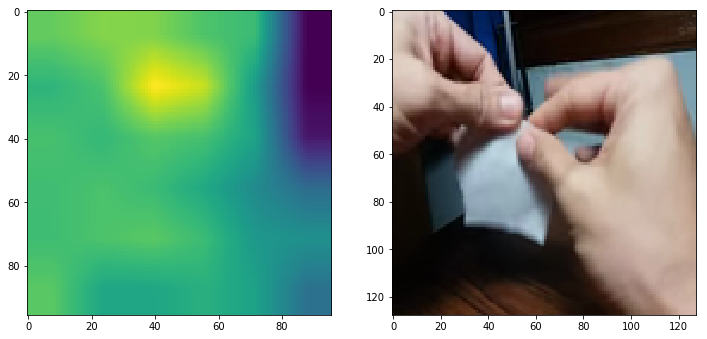

20


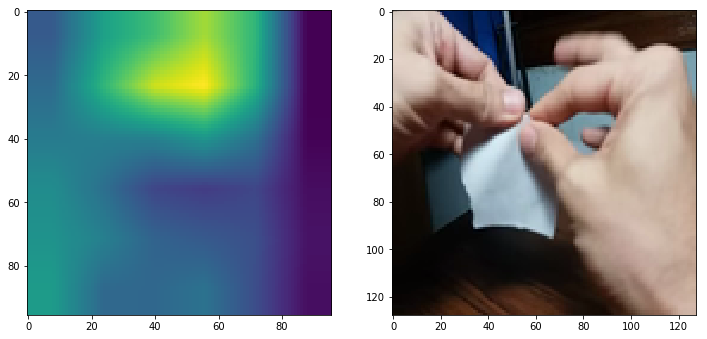

21


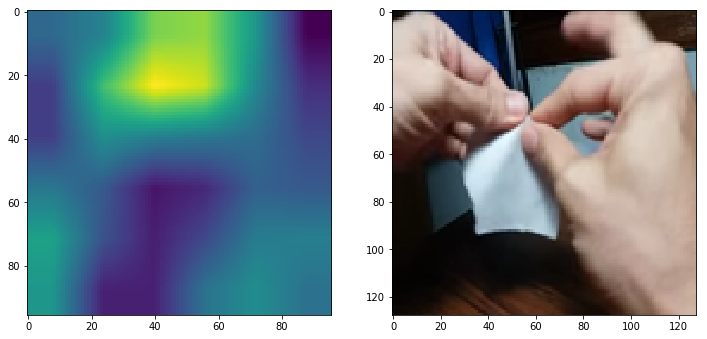

22


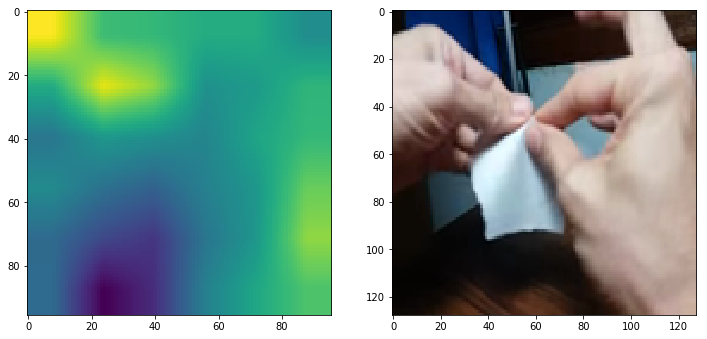

23


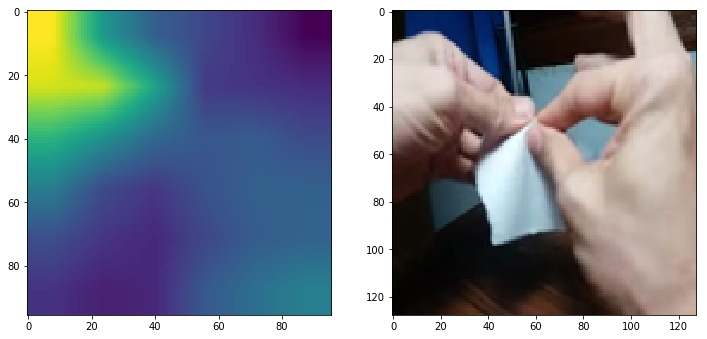

24


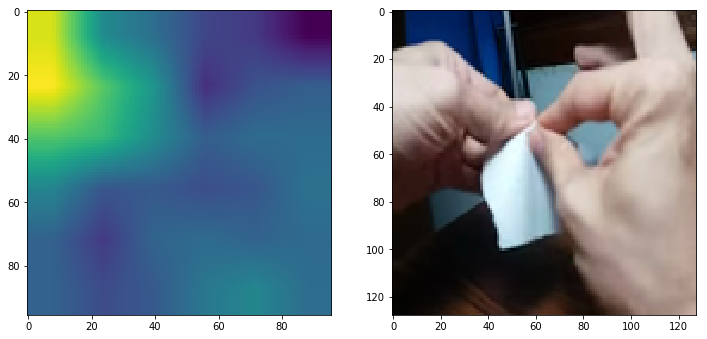

25


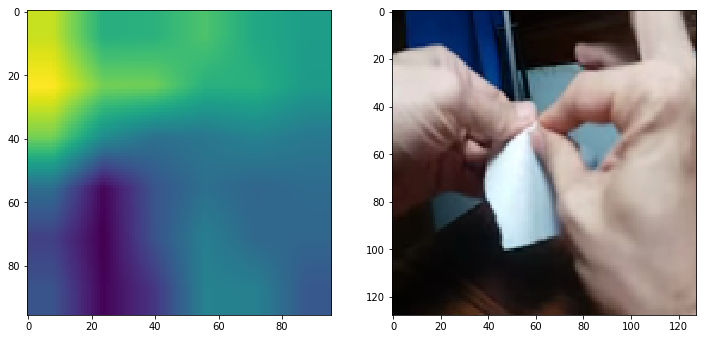

26


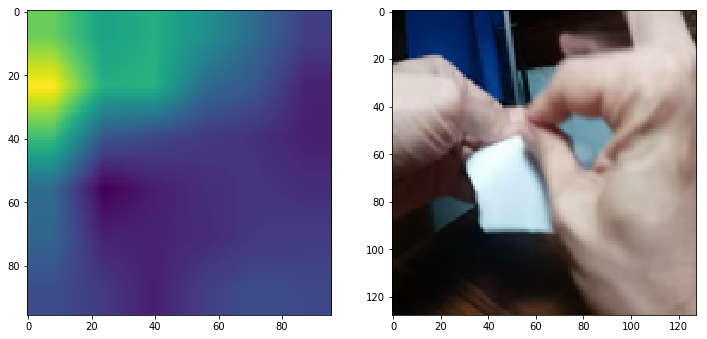

27


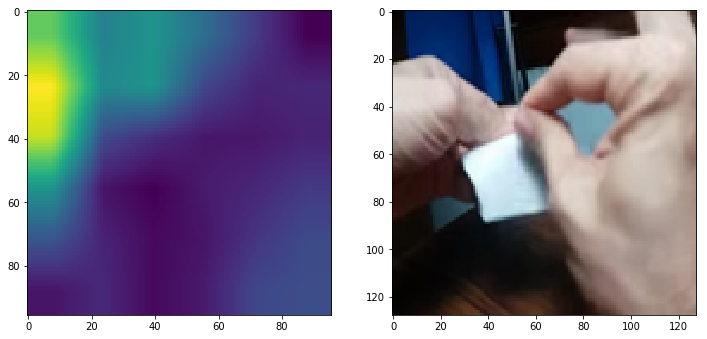

28


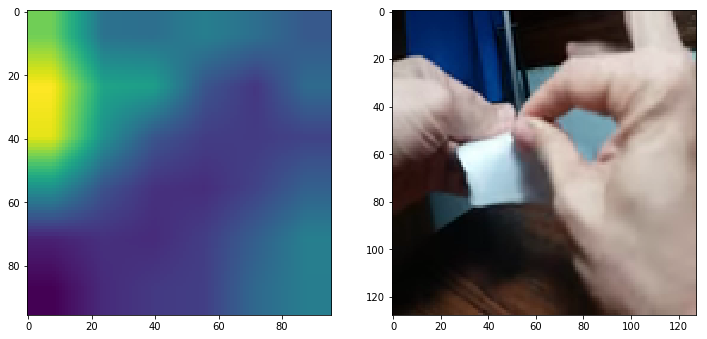

29


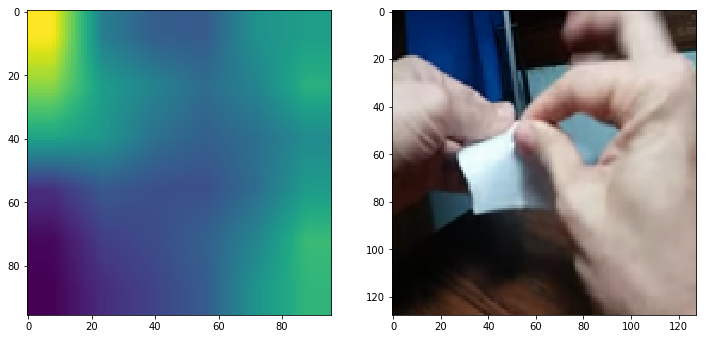

30


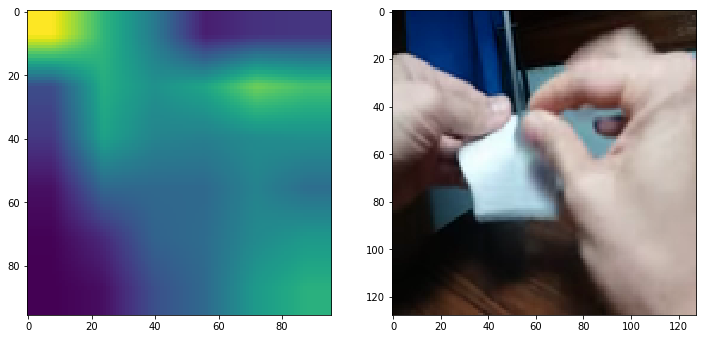

31


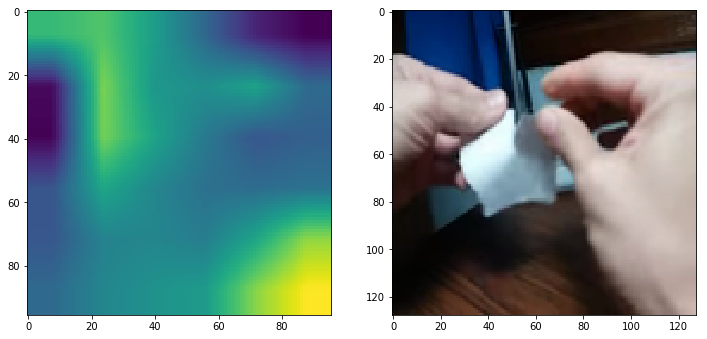

32


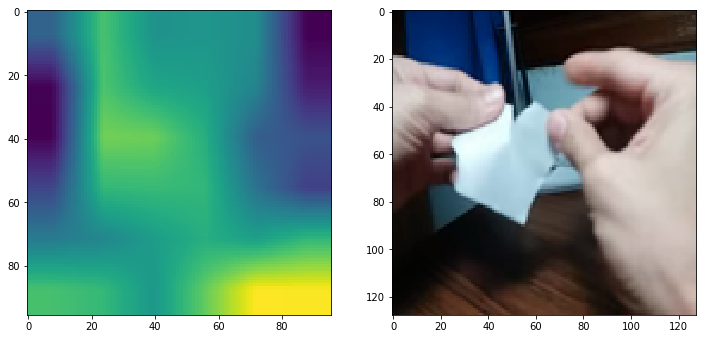

33


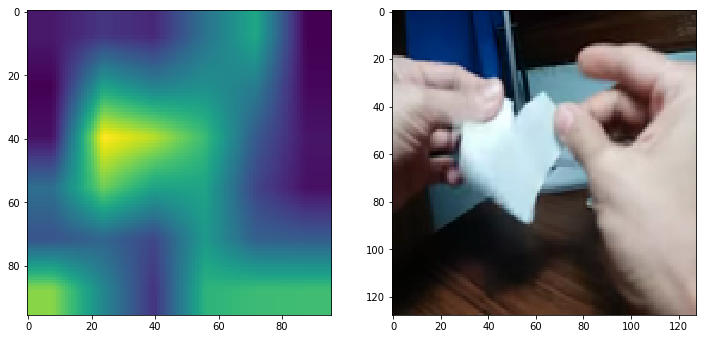

34


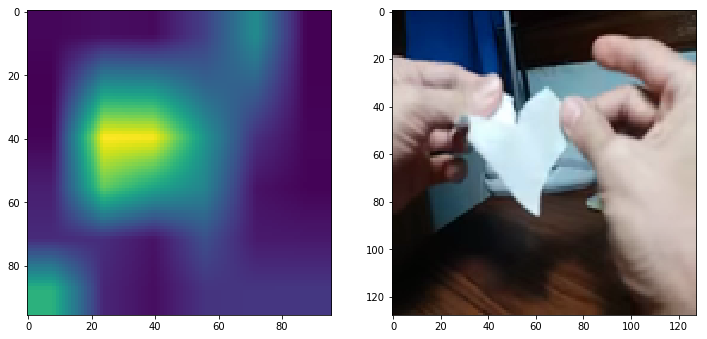

35


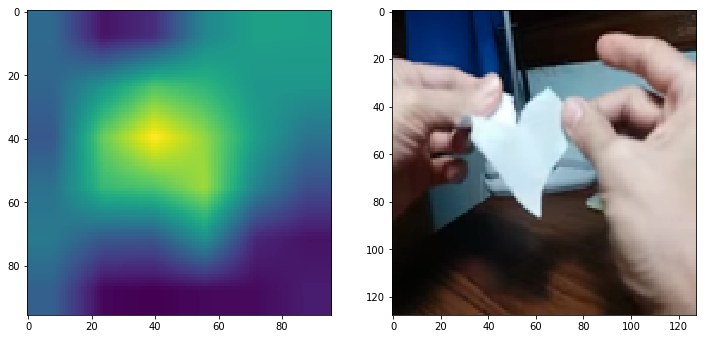

36


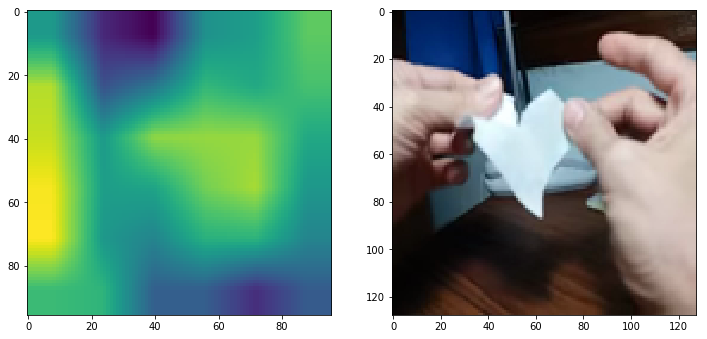

37


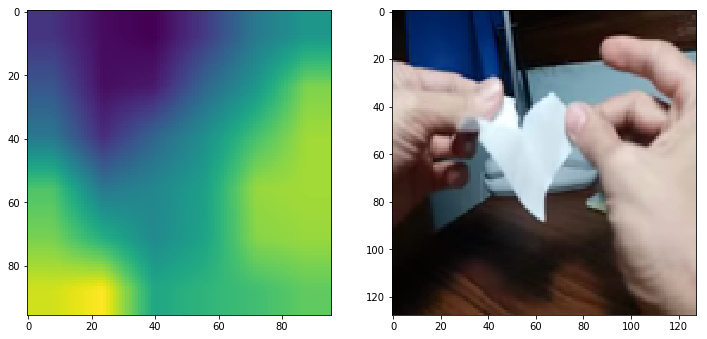

38


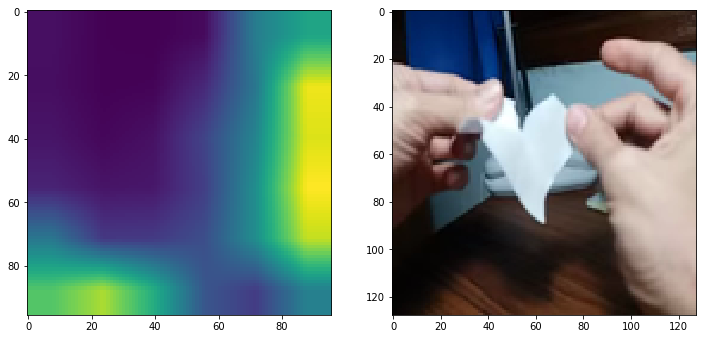

39


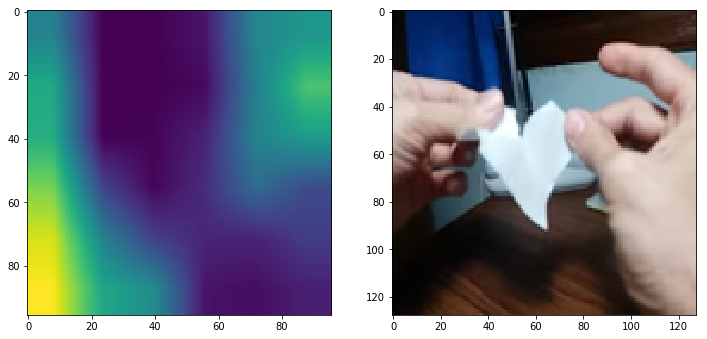

40


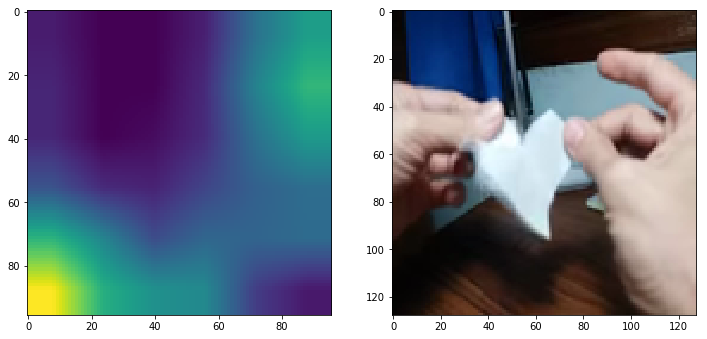

41


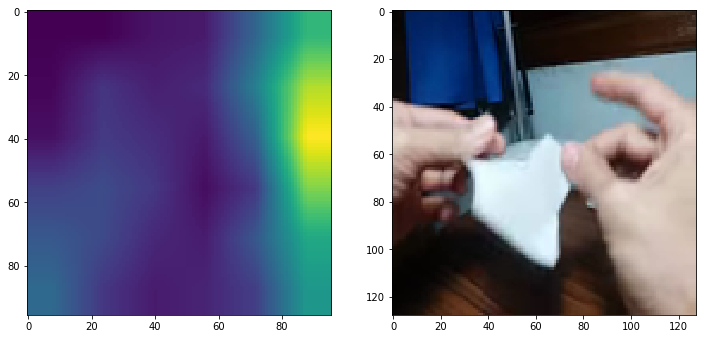

42


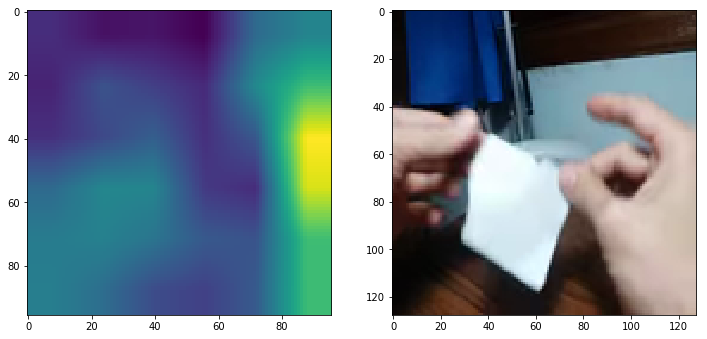

43


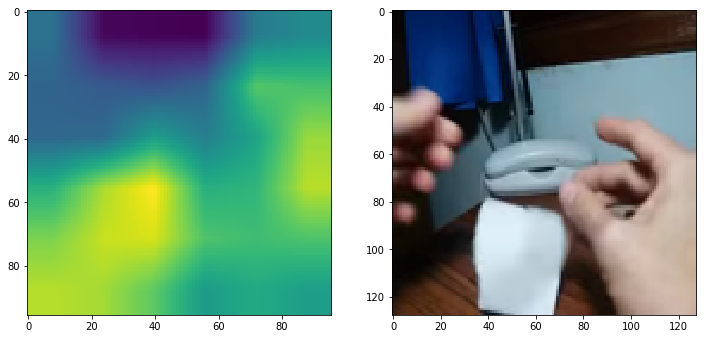

44


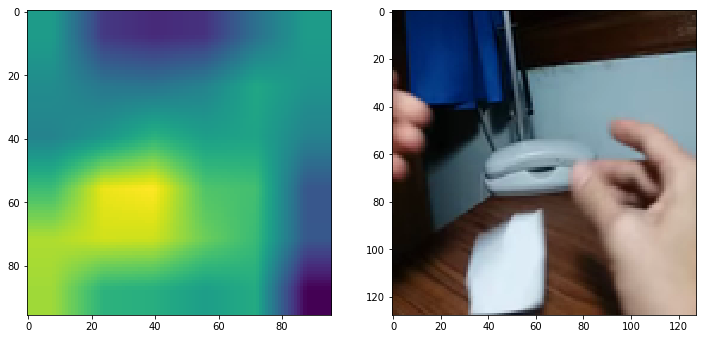

45


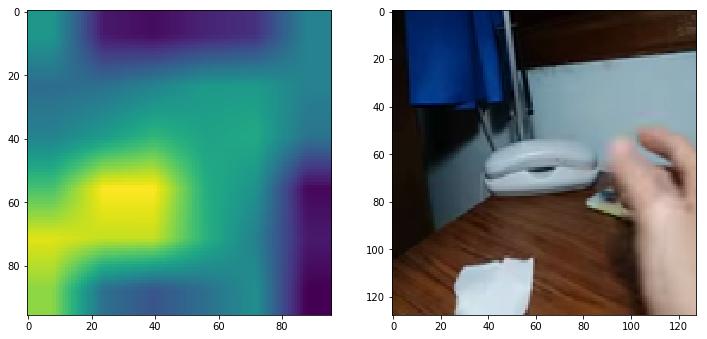

46


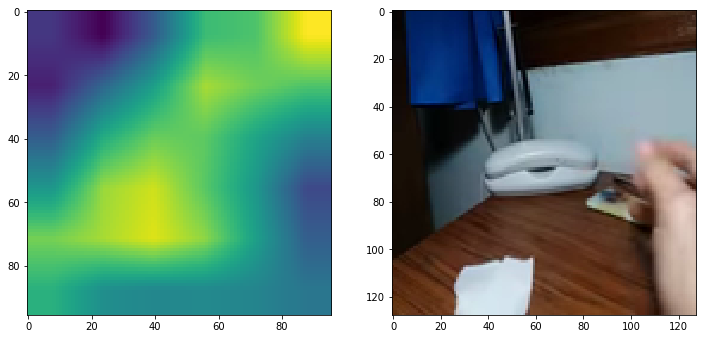

47


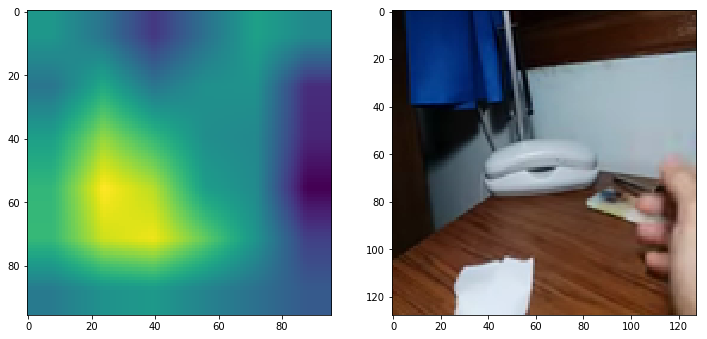

48


IndexError: index 48 is out of bounds for axis 0 with size 48

In [126]:
path_to_video, _, classif_label = next(path_gen)
# path_to_video = '/data/20bn-something-something-v2/62082.webm'
#path_to_video = '/data/20bn-something-something-v2/149631.webm'
#path_to_video = '/data/20bn-something-something-v2/51345.webm'

# classif_label = 47

video_uint8 = reader.open(path_to_video)
video = preprocessor(video_uint8)
video = Variable(torch.from_numpy(video[None]), volatile=False).cuda()
empty_caption = Variable(torch.zeros([1, 1]), volatile=True).long().cuda()


vocab_size = 178

all_cams = []


target_index =  classif_label

##model
net_output  = run_model(net, (video, empty_caption))
_,predind  = torch.max(net_output, dim=1)
print("pppppp"*10)


net2_output, layer_feats, gradients = run_model2(net,video )
_, goh2 = torch.max(net2_output , dim=1)


print(int2label[classif_label])
print( [classif_label])
print( [predind.data.cpu().numpy()[0]])
print( [goh2.data.cpu().numpy()[0]])
print("*"*15)
cam = calc_cam(net, net2_output, layer_feats, target_index, vocab_size, gradients, frame_number=-7)


for ff in range(0,video_uint8.shape[0]):
    print(ff)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    single_cam = cam[ff,:,:]
    single_cam = cv2.resize(single_cam, (96, 96))
    single_cam = single_cam - np.min(cam)
    single_cam = single_cam / np.max(cam)
    if (ff==0):
        prev_cam = single_cam
    single_cam = prev_cam*0.2 + single_cam*0.8
    prev_cam = single_cam
    
    plt.imshow(single_cam)
    plt.subplot(1, 2, 2)
    plt.imshow(video_uint8[ff])
    plt.show()
    all_cams.append(single_cam)

In [130]:
# unnormalize_op = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# input_data_unnormalised = unnormalize_op(video.data.cpu().squeeze(0))
input_data_unnormalised = (64. * video.data.cpu().squeeze(0)) / 255.
input_data_unnormalised = input_data_unnormalised.permute(1, 2, 3, 0).numpy()  # (16x224x224x3)
input_data_unnormalised = np.flip(input_data_unnormalised, 3)

output_images_folder_cam_combined = os.path.join("cam_saved_images", "/home/farzaneh/cam2/", "combined")

output_images_folder_original = os.path.join("cam_saved_images", "/home/farzaneh/cam2/", "original")
output_images_folder_cam = os.path.join("cam_saved_images", "/home/farzaneh/cam2", "cam")

os.makedirs(output_images_folder_cam_combined, exist_ok=True)
os.makedirs(output_images_folder_cam, exist_ok=True)
os.makedirs(output_images_folder_original, exist_ok=True)

 
RESIZE_SIZE = 96
RESIZE_FLAG = 1
SAVE_INDIVIDUALS = 1
for i in range(len(all_cams)):
    input_data_img = input_data_unnormalised[i, :, :, :]
    heatmap = cv2.applyColorMap(np.uint8(255 * all_cams[i]), cv2.COLORMAP_JET)
    if RESIZE_FLAG:
        input_data_img = cv2.resize(input_data_img, (RESIZE_SIZE, RESIZE_SIZE))
        heatmap = cv2.resize(heatmap, (RESIZE_SIZE, RESIZE_SIZE))
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(input_data_img)
    cam = cam / np.max(cam)
    combined_img = np.concatenate((np.uint8(255 * input_data_img), np.uint8(255 * cam)), axis=1)
    
    cv2.imwrite(os.path.join(output_images_folder_cam_combined, "img%02dg.jpg" % (i + 1)), combined_img)
    if SAVE_INDIVIDUALS:
        cv2.imwrite(os.path.join(output_images_folder_cam, "img%02d.jpg" % (i + 1)), np.uint8(255 * cam))
        cv2.imwrite(os.path.join(output_images_folder_original, "img%02d.jpg" % (i + 1)), np.uint8(255 * input_data_img))

In [131]:
path_to_combined_gif = os.path.join(output_images_folder_cam_combined, "mygif.gif")
os.system("convert -delay 10 -loop 0 {}.jpg {}".format(
                                    os.path.join(output_images_folder_cam_combined, "*"),
                                    path_to_combined_gif))

0

In [132]:
path_to_video
'Moving [something] and [something] away from each other'

'Moving [something] and [something] away from each other'

In [122]:
output_images_folder_cam_combined


'/home/farzaneh/cam/combined'